## 3.2  Analysis of dToU users behavioural changes

In this section we will calculate the consumption and price of electricity paid by each dToU user in 2013. We will also calculate both values for each user in 2012 to know how each individual user has changed his electricity consumption behaviour:

-Total consumption

-Price paid per kWh: a lower mean price would indicate that the user has indeed tried to increase his consumption when prices were low and decrease if when the tariff was high.

The commented lines are not necessary with the configuration in our Virtual Machine.

In [4]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark import sqlContext
from datetime import datetime
import numpy as np
from pyspark import Row
sc

In [1]:
path = 'Power-Networks-LCL-June2015.bz2'

In [2]:
data = sc.textFile(path)

In [3]:
data.take(5)

[u'Archive:  Power-Networks-LCL-June2015(withAcornGps).zip',
 u'  inflating: Power-Networks-LCL-June2015(withAcornGps)v2.csv  ',
 u'LCLid,stdorToU,DateTime,KWH/hh (per half hour) ,Acorn,Acorn_grouped',
 u'MAC000002,Std,2012-10-12 00:30:00.0000000, 0 ,ACORN-A,Affluent',
 u'MAC000002,Std,2012-10-12 01:00:00.0000000, 0 ,ACORN-A,Affluent']

In [5]:
data_no_header = data.zipWithIndex().filter(lambda x: x[1] > 2).keys()

In [6]:
def line2tuple(l):
    fields = l.split(',')
    if len(fields) == 6: 

#We have seen that there is at least one line in the file that does not follow the format.
#This condition is to avoid an "Index out of range" error. 
        ID = fields[0]
        tariff = fields[1]
        DateTime = fields[2]
        ACORN = fields[4]
        ACORN_grouped = fields[5]
        try:
            consumption = float(fields[3])
        except ValueError:
            consumption = np.nan
        return (ID, tariff, DateTime, consumption,ACORN,ACORN_grouped)
    else:
        return (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)
   
#We treat any line that does not follow the general format as NaN. 
#We will remove them afterwards

In [7]:
rows = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4,_5): t == 'ToU')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4]
                   ,ACORN_grouped = x[5] ))

In [8]:
df = rows.toDF()
df.printSchema

<bound method DataFrame.printSchema of DataFrame[ACORN: string, ACORN_grouped: string, DateTime: string, ID: string, kWh_30min: double]>

In [9]:
from pyspark.sql.types import TimestampType
df = df.withColumn('DateTime', df['DateTime'].cast(TimestampType()))

In [7]:
#Download tariffs
!wget 'https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx'

--2017-04-23 12:40:47--  https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx
Resolving files.datapress.com (files.datapress.com)... 54.230.79.118, 54.230.79.137, 54.230.79.21, ...
Connecting to files.datapress.com (files.datapress.com)|54.230.79.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245384 (240K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Tariffs.xlsx’

Tariffs.xlsx        100%[===================>] 239.63K  1.54MB/s    in 0.2s    

2017-04-23 12:40:48 (1.54 MB/s) - ‘Tariffs.xlsx’ saved [245384/245384]



In [10]:
import pandas as pd
tariffs = pd.read_excel('Tariffs.xlsx')

In [124]:
tariffs.head(5)

,TariffDateTime,Tariff
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


We need the actual values of the tariff, so High = 67.20p/kWh, Low = 3.99p/kWh and Normal = 11.76p/kWh.

In [11]:
tariffs.ix[tariffs['Tariff'] == 'Normal', 'Tariff_value'] = 11.76
tariffs.ix[tariffs['Tariff'] == 'High', 'Tariff_value'] = 67.20
tariffs.ix[tariffs['Tariff'] == 'Low', 'Tariff_value'] = 3.99

In [12]:
tariffs = tariffs.rename(columns = {'TariffDateTime' : 'DateTime'})

In [13]:
tariffs.sample(5)

,DateTime,Tariff,Tariff_value
3367,2013-03-12 03:30:00,Normal,11.76
8583,2013-06-28 19:30:00,Normal,11.76
12512,2013-09-18 16:00:00,Normal,11.76
15924,2013-11-28 18:00:00,Normal,11.76
10347,2013-08-04 13:30:00,Normal,11.76


In [14]:
tariffs = tariffs.drop('Tariff', axis = 1)

In [15]:
tariffs['DateTime'] = tariffs['DateTime'].astype(str)

In [16]:
t = sqlContext.createDataFrame(tariffs) 

In [17]:
t = t.withColumn('DateTime', t['DateTime'].cast(TimestampType()))

In [ ]:
t.show(3)

Now we can join consumption and tariff data and calculate the price paid for each measurement point: Consumption * Tariff 

In [18]:
import pyspark.sql.functions as F

In [133]:
joined = df.filter(F.year('DateTime') == 2013).join(t, 'DateTime', 'left_outer')\
    .withColumn('price', df.kWh_30min*t.Tariff_value)

In [134]:
ToU_by_ID = joined.dropna().groupBy('ID', 'ACORN', 'ACORN_grouped')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.sum('price').alias('sum_price')
        )

In [135]:
ToU_by_ID.toPandas().to_csv('outputs/ToU_by_ID.csv')

In [136]:
ToU_by_ID_Tariff = joined.dropna()\
    .groupBy('ID', 'ACORN', 'ACORN_grouped', 'Tariff_value')\
    .agg(F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.min('kWh_30min').alias('min_consumption'),
         F.max('kWh_30min').alias('max_consumption'),
         F.stddev('kWh_30min').alias('stddev_consumption'),
         F.sum('price').alias('sum_price')
        )

In [137]:
ToU_by_ID_Tariff.toPandas().to_csv('outputs/ToU_by_ID_Tariff.csv')

In [138]:
ToU_by_ID_hour = joined.dropna()\
    .groupBy('ID', 'ACORN', 'ACORN_grouped', F.month('DateTime').alias('Month'), 
             F.hour('DateTime').alias('Hour'))\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.min('kWh_30min').alias('min_consumption'),
         F.max('kWh_30min').alias('max_consumption'),
         F.stddev('kWh_30min').alias('stddev_consumption'),
         F.sum('price').alias('sum_price')
        )

In [139]:
ToU_by_ID_hour.toPandas().to_csv('outputs/ToU_by_ID_hour.csv')

In order to compare consumption of ToU users in 2012 (with standard flat rate tariff) and 2013 (with dToU) we will perform the same aggregations with 2012 data as we did with 2013. Then we will be able to study how each user has changed his consumption behavioural patterns (e.g. if they have really shifted to lower tariffs or by chance their usual consumption was already when tariffs happened to be low). For this purpose we propose joining 2012 consumption data to 2013 dToU tariff prices and study these consumption shifts.

In order to join 2012 data with the tariff dataframe, we need to add one year to all timestamps. Pyspark SQL Contexto provides the function add_months and date_add which could be very handy... but they keep only the date (not the time).

In [ ]:
df.filter(F.year('DateTime') == 2012)\
    .withColumn('DateTime',F.add_months(df['DateTime'],12)).take(3)

In [ ]:
df.filter(F.year('DateTime') == 2012)\
    .withColumn('DateTime',F.date_add(df['DateTime'],366)).take(3)

Therefore we need to convert the DateTime column to Unix timestamps (in seconds), add one year in seconds and convert it back to TimestampType. We have to bear in mind that 2012 was a leap year so we have to add $366·24·60·60$ seconds.

In [140]:
df.filter(F.year('DateTime') == 2012)\
    .withColumn('DateTime',(F.unix_timestamp(df['DateTime'])+366*24*60*60).cast(TimestampType()))\
    .take(3)

[Row(ACORN=u'ACORN-C', ACORN_grouped=u'Affluent', DateTime=datetime.datetime(2013, 6, 2, 10, 30), ID=u'MAC000005', kWh_30min=0.095),
 Row(ACORN=u'ACORN-C', ACORN_grouped=u'Affluent', DateTime=datetime.datetime(2013, 6, 2, 11, 0), ID=u'MAC000005', kWh_30min=0.051),
 Row(ACORN=u'ACORN-C', ACORN_grouped=u'Affluent', DateTime=datetime.datetime(2013, 6, 2, 11, 30), ID=u'MAC000005', kWh_30min=0.098)]

In [19]:
joined12 = df.filter(F.year('DateTime') == 2012)\
.withColumn('DateTime',(F.unix_timestamp(df['DateTime'])+366*24*60*60).cast(TimestampType()))\
.join(t, 'DateTime', 'left_outer').withColumn('price', df.kWh_30min*t.Tariff_value)

In [28]:
joined12.take(3)

[Row(DateTime=datetime.datetime(2013, 1, 2, 8, 0), ACORN=u'ACORN-E', ACORN_grouped=u'Affluent', ID=u'MAC000015', kWh_30min=0.12, Tariff_value=11.76, price=1.4112),
 Row(DateTime=datetime.datetime(2013, 1, 2, 8, 0), ACORN=u'ACORN-C', ACORN_grouped=u'Affluent', ID=u'MAC000017', kWh_30min=0.212, Tariff_value=11.76, price=2.49312),
 Row(DateTime=datetime.datetime(2013, 1, 2, 8, 0), ACORN=u'ACORN-Q', ACORN_grouped=u'Adversity', ID=u'MAC000031', kWh_30min=0.16, Tariff_value=11.76, price=1.8816)]

In [144]:
ToU_by_ID_hour.unpersist()

DataFrame[ID: string, ACORN: string, ACORN_grouped: string, Month: int, Hour: int, count: bigint, mean_consumption: double, sum_consumption: double, min_consumption: double, max_consumption: double, stddev_consumption: double, sum_price: double]

In [145]:
joined.unpersist()

DataFrame[DateTime: timestamp, ACORN: string, ACORN_grouped: string, ID: string, kWh_30min: double, Tariff_value: double, price: double]

In [20]:
ToU_by_ID_hour_2012 = joined12.dropna()\
    .groupBy('ID', 'ACORN', 'ACORN_grouped', F.month('DateTime').alias('Month'), 
             F.hour('DateTime').alias('Hour'))\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.min('kWh_30min').alias('min_consumption'),
         F.max('kWh_30min').alias('max_consumption'),
         F.stddev('kWh_30min').alias('stddev_consumption'),
         F.sum('price').alias('sum_price')
        )

In [21]:
ToU_by_ID_hour_2012.toPandas().to_csv('outputs/ToU_by_ID_hour_2012.csv')

Let us calculate the consumption of standard users during 2013 and that of ToU users during 2012.

In [ ]:
Std_by_ID_2013 = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4): t == 'Std')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4])).toDF()

In [ ]:
Std_by_ID_2013 = \
Std_by_ID_2013.withColumn('DateTime', Std_by_ID_2013['DateTime'].cast(TimestampType()))\
.filter(F.year('DateTime') == 2013).groupBy('ID', 'ACORN', 'ACORN_grouped')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
        )

In [ ]:
Std_by_ID_2013.toPandas().to_csv('outputs/Std_by_ID_2013.csv')

In [ ]:
ToU_by_ID_2012 = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4): t == 'ToU')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4])).toDF()

In [ ]:
ToU_by_ID_2012_a = ToU_by_ID_2012\
.withColumn('DateTime', ToU_by_ID_2012['DateTime'].cast(TimestampType()))\
.filter(F.year('DateTime') == 2012).groupBy('ID', 'ACORN', 'ACORN_grouped')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption')
        )

In [ ]:
ToU_by_ID_2012_a.toPandas().to_csv('outputs/ToU_by_ID_2012.csv')

#### Exploring and drawing aggregate data

Now we can use Python (pandas and matplotlib/seaborn) to answer some questions.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [74]:
ToU_users_2013 = pd.read_csv('outputs/ToU_by_ID.csv', index_col=0)

In [75]:
ToU_users_2013.sample(5)

,ID,ACORN,ACORN_grouped,count,mean_consumption,sum_consumption,sum_price
766,MAC001281,ACORN-F,Comfortable,7688,0.031051,238.719000,3233.690670
1101,MAC001179,ACORN-Q,Adversity,17536,0.241186,4229.436000,58470.727767
154,MAC003145,ACORN-H,Comfortable,17536,0.075604,1325.799999,14690.708967
209,MAC003461,ACORN-J,Comfortable,17534,0.140809,2468.938000,36397.643101
363,MAC002061,ACORN-F,Comfortable,17535,0.096726,1696.095000,23183.239590


We can calculate the mean price paid by each user as:

$$\frac{\sum_{i=t_1}^{i=t_N} Consumption*Price}{\sum_{i=t_1}^{i=t_N} Consumption}$$

with t_1 and t_N the first and last timestamp of the time series, respectively.

We have calculated the numerator in the "sum_price" variable.

In [76]:
ToU_users_2013['mean_price'] = ToU_users_2013['sum_price']/ToU_users_2013['sum_consumption']

In [77]:
ToU_users_2013.sample(5)

,ID,ACORN,ACORN_grouped,count,mean_consumption,sum_consumption,sum_price,mean_price
46,MAC002915,ACORN-H,Comfortable,17534,0.278487,4882.984001,67648.981274,13.854025
619,MAC003272,ACORN-H,Comfortable,17536,0.419245,7351.885999,103389.834838,14.063036
292,MAC002593,ACORN-E,Affluent,17533,0.046167,809.447000,11079.342120,13.687545
276,MAC002625,ACORN-E,Affluent,17530,0.231935,4065.823999,57620.060820,14.171804
1092,MAC003988,ACORN-O,Adversity,17536,0.062472,1095.504000,14812.881304,13.521522


It is worth reminding that the standard flat rate tariff is 14.228pence/kWh. That means that all users who have paid a lower mean price than this value have profited from dToU tariff and responded positively to its stimuli.

In [8]:
std_price = 14.228

In [78]:
ToU_users_2013['mean_price'].describe()

count    1117.000000
mean       13.817777
std         0.493073
min        11.080637
25%        13.602893
50%        13.839240
75%        14.086855
max        17.182524
Name: mean_price, dtype: float64

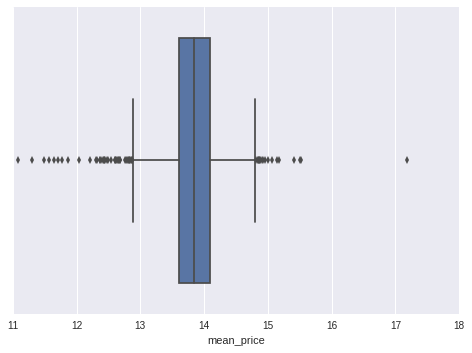

In [39]:
_ = sns.boxplot(x=ToU_users_2013['mean_price'])

In [10]:
from scipy import stats
stats.percentileofscore(ToU_users_2013['mean_price'],14.228)

85.317815577439575

85% of the users paid less for their kWh than the standard flat rate tariff user. It is possible than some of these did not really react to tariff changes, but it is clear that the remaining 15% did not react to dToU.

In [79]:
ToU_users_2013['mean_price'].describe()/std_price

count    78.507169
mean      0.971168
std       0.034655
min       0.778791
25%       0.956065
50%       0.972676
75%       0.990080
max       1.207656
Name: mean_price, dtype: float64

The median dToU user paid 2.7% per kWh. Mean and median values are close to each other, but there are more outliers in the lower range than in the upper one. The smartest user paid over 28% less for his consumption!

##### Now we will investigate whether different socioeconomic consumer groups respond in different ways to the same dynamic tariff.

ACORN is a socioeconomic segmentation which attempts to describe customer behaviour used in the UK. There are 6 top-level groups which are further segregated into the lower-level segments defined by a letter as we have in our dataset. These are defined as follows:

Affluent Achievers:

-A: Lavish Lifestyles

-B: Executive Wealth

-C: Mature Money


Rising Prosperity:

-D: City Sophisticates

-E: Career Climbers


Comfortable Communities:

-F: Countryside Communities

-G: Successful Suburbs

-H: Steady Neighbourhoods

-I: Comfortable Seniors

-J: Starting Out


Financially Stretched:

-K: Student Life

-L: Modest means

-M: Striving Families

-N: Poorer Pensioners


Urban Adversity

-O: Young Hardship

-P: Struggling Estates

-Q: Difficult Circumstances


Not Private Households:

-R: Not Private Households

For more information refer to:
http://acorn.caci.co.uk/downloads/Acorn-User-guide.pdf

In [12]:
ACORN_levels = ToU_users_2013['ACORN'].unique()

In [13]:
ACORN_levels.sort()
ACORN_levels

array(['ACORN-', 'ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'ACORN-Q',
       'ACORN-U'], dtype=object)

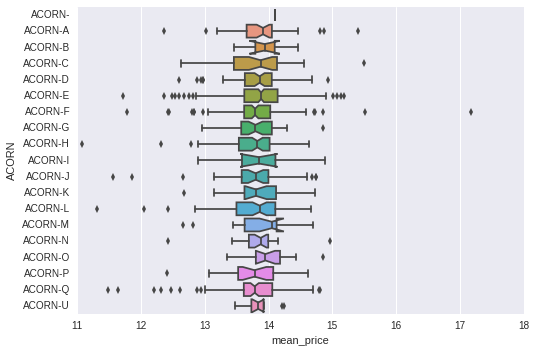

In [14]:
_ = sns.boxplot(x='mean_price', y='ACORN', data=ToU_users_2013
                , order = ACORN_levels, notch = True)

In [81]:
ToU_users_2013['ACORN_grouped'].unique()

array(['Comfortable', 'Affluent', 'Adversity', 'ACORN-U', 'ACORN-'], dtype=object)

In [85]:
ToU_users_2013.loc[(ToU_users_2013['ACORN_grouped'] == 'ACORN-U') 
               | (ToU_users_2013['ACORN_grouped'] == 'ACORN-'),'ACORN_grouped'] = 'Undefined'

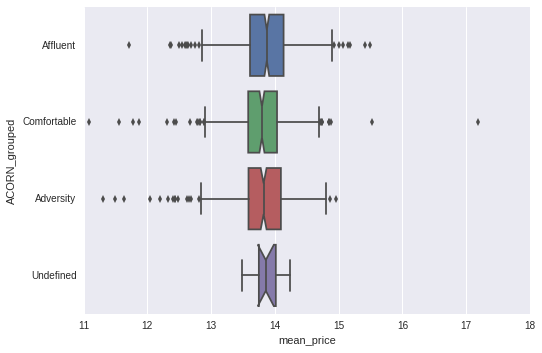

In [87]:
_ = sns.boxplot(x='mean_price', y='ACORN_grouped', data=ToU_users_2013,
                order = ['Affluent', 'Comfortable', 'Adversity', 'Undefined'],  notch = True)

Looking at coarser ACORN groups it seems that comfortable (middle-class) users tend to have a better response to dToU than affluent (upper-class) users.

In [15]:
ACORN_price = ToU_users_2013.groupby('ACORN')['mean_price'].describe().unstack(level=1)
ACORN_price

,count,mean,std,min,25%,50%,75%,max
ACORN,,,,,,,,
ACORN-,1.0,14.106420,NaN,14.106420,14.106420,14.106420,14.106420,14.106420
ACORN-A,39.0,13.895414,0.519119,12.368000,13.656511,13.913826,14.053020,15.408785
ACORN-B,4.0,13.951253,0.411142,13.461324,13.793319,13.939159,14.097093,14.465370
ACORN-C,34.0,13.798230,0.547480,12.621159,13.456766,13.875074,14.133313,15.498438
ACORN-D,73.0,13.835792,0.411399,12.595315,13.628556,13.859890,14.051135,14.928961
ACORN-E,338.0,13.865832,0.460832,11.711281,13.620310,13.884152,14.142797,15.179523
ACORN-F,151.0,13.813675,0.516405,11.775736,13.617926,13.789527,14.027534,17.182524
ACORN-G,47.0,13.788401,0.338923,12.952387,13.572028,13.795620,14.052287,14.846828
ACORN-H,83.0,13.737643,0.522644,11.080637,13.534704,13.825183,14.017218,14.639255


In [18]:
ACORN_price['mean'].sort_values()[:3]

ACORN
ACORN-J    13.723183
ACORN-H    13.737643
ACORN-L    13.751310
Name: mean, dtype: float64

In [19]:
ACORN_price['50%'].sort_values()[:3]

ACORN
ACORN-P    13.780527
ACORN-Q    13.783004
ACORN-F    13.789527
Name: 50%, dtype: float64

In [20]:
ACORN_price['50%'].sort_values(ascending=False)[:3]

ACORN
ACORN-     14.106420
ACORN-M    14.049996
ACORN-O    13.952387
Name: 50%, dtype: float64

In [21]:
ACORN_price['25%'].sort_values()[:3]

ACORN
ACORN-C    13.456766
ACORN-L    13.497138
ACORN-P    13.523571
Name: 25%, dtype: float64

In [22]:
ACORN_price['25%'].sort_values(ascending=False)[:3]

ACORN
ACORN-     14.106420
ACORN-O    13.801162
ACORN-B    13.793319
Name: 25%, dtype: float64

In [23]:
ACORN_price['75%'].sort_values()[:3]

ACORN
ACORN-U    13.922001
ACORN-N    13.996473
ACORN-J    13.999242
Name: 75%, dtype: float64

In [24]:
ACORN_price['std'].sort_values(ascending=False)[:5]

ACORN
ACORN-J    0.699752
ACORN-I    0.609306
ACORN-M    0.559435
ACORN-L    0.555139
ACORN-C    0.547480
Name: std, dtype: float64

In [25]:
ACORN_price['min'].sort_values()[:3]

ACORN
ACORN-H    11.080637
ACORN-L    11.307295
ACORN-Q    11.486705
Name: min, dtype: float64

In [26]:
ACORN_price['max'].sort_values(ascending=False)[:3]

ACORN
ACORN-F    17.182524
ACORN-C    15.498438
ACORN-A    15.408785
Name: max, dtype: float64

The lowest median is that P, Q and F groups. P and Q are low income groups.

-P is described as a mixture of poorer families with many children, low income terraced housing, multi-ethnic, purpose-built estates and low income families in social rented semis.

-Q users are single parents and families in social rented flats, singles and young families (some receiving benefits) and people living in deprived areas and high-rise flats.

Both of these groups have several outliers in the lower part of the mean price spectrum but only one in the higher part. Their maximum is 14.8 p/kWh, less than 0.6 above the standard flat rate tariff. These users are used to hardship and are prone to take any opportunity to save money.

-F users are countryside communities. These have a very large variability, with the top payer (nearly 3 p/kWh over the standard flat rate tariff) in this group.

-The worst group is M, with only 17 users. These are a mixture of struggling young families in post-war terraces, people with limited means in post-war estates, semi-rural estates and families in right-to-buy estates. There is a large amount of lone parents, people enjoying benefits and lower than average internet, smartphone and tablet use.

-Group E has a large variability, with many outliers in the lower and upper ranges. It is composed by young career-driven families, first buyers and people living in mixed metropolitan areas. They are educated young people rising in prosperity, with heavy internet use (including online shopping). They own smartphones, tablets and other technological devices in a larger degree than the average British. Some have a strong positive reaction to dToU, others seem not to care about changing their consumption habits and end up paying more for their electricity.

-Group D is related to E and seems to behave in a more consistent way, although some users also to not react to the dynamic tariff. These are urban cosmopolitan young people, living in smaller flats and metropolitan areas.

Let us examine now the consumption behaviour (regardless on the tariff of each group).

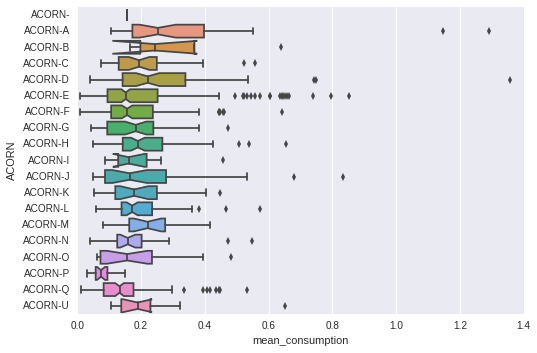

In [80]:
_ = sns.boxplot(x='mean_consumption', y='ACORN', data=ToU_users_2013
                , order = ACORN_levels, notch = True)

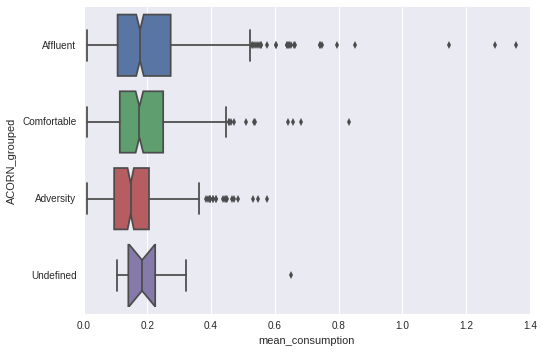

In [86]:
_ = sns.boxplot(x='mean_consumption', y='ACORN_grouped', data=ToU_users_2013,
                order = ['Affluent', 'Comfortable', 'Adversity', 'Undefined'],  notch = True)

There seems to be a link between wealth and electricity consumption (upper and middle classes consume significantly more on average than the less wealthy customers).

In [28]:
ACORN_cons = ToU_users_2013.groupby('ACORN')['mean_price'].describe().unstack(level=1)
ACORN_cons

,count,mean,std,min,25%,50%,75%,max
ACORN,,,,,,,,
ACORN-,1.0,14.106420,NaN,14.106420,14.106420,14.106420,14.106420,14.106420
ACORN-A,39.0,13.895414,0.519119,12.368000,13.656511,13.913826,14.053020,15.408785
ACORN-B,4.0,13.951253,0.411142,13.461324,13.793319,13.939159,14.097093,14.465370
ACORN-C,34.0,13.798230,0.547480,12.621159,13.456766,13.875074,14.133313,15.498438
ACORN-D,73.0,13.835792,0.411399,12.595315,13.628556,13.859890,14.051135,14.928961
ACORN-E,338.0,13.865832,0.460832,11.711281,13.620310,13.884152,14.142797,15.179523
ACORN-F,151.0,13.813675,0.516405,11.775736,13.617926,13.789527,14.027534,17.182524
ACORN-G,47.0,13.788401,0.338923,12.952387,13.572028,13.795620,14.052287,14.846828
ACORN-H,83.0,13.737643,0.522644,11.080637,13.534704,13.825183,14.017218,14.639255


We have shown that over 85% of users saved money and that there is a large spread in mean price, among all users and also within ACORN socioeconomic groups. 

However, the fact that a user has paid considerably less for his kWh does not necessarily mean that they have changed their behaviour - or if they have paid more than with the flat rate tariff it could be that they had a reaction. If a user's habits make him concentrate most of his consumption in the hours were tariffs are high and he cannot avoid using electricity during this time he will pay more, even if he manages to cut his consumption.

Therefore, to answer properly this question, we should study the changes in consumer consumption habits in 2012, when they used the flat rate standard tariff, and 2013, when they were subjected to the Dynamic Time of Use (dToU) tariff.

We have aggregated the consumption of each dToU user in 2012 and 2013 by month and hour.

In [23]:
ToU_hour_2013 = pd.read_csv('outputs/ToU_by_ID_hour.csv', index_col=0)

In [24]:
ToU_hour_2013.sample(5)

,ID,ACORN,ACORN_grouped,Month,Hour,count,mean_consumption,sum_consumption,min_consumption,max_consumption,stddev_consumption,sum_price
40342,MAC005515,ACORN-E,Affluent,3,11,62,0.163532,10.139,0.017,1.116,0.195034,95.940182
45041,MAC004837,ACORN-F,Comfortable,9,10,60,0.216917,13.015,0.007,1.495,0.299909,160.113660
85527,MAC004811,ACORN-Q,Adversity,3,10,62,0.070548,4.374,0.028,0.303,0.043984,46.698540
140279,MAC003390,ACORN-O,Adversity,6,9,60,0.060133,3.608,0.026,0.126,0.029637,45.472560
85435,MAC003387,ACORN-C,Affluent,1,1,62,0.047581,2.950,0.014,0.148,0.027185,47.102160


In [25]:
ToU_hour_2013 = ToU_hour_2013.rename(columns={'month(DateTime)':'Month', 'hour(DateTime)':'Hour'})

In [26]:
ToU_hour_2013['mean_price'] = ToU_hour_2013['sum_price']/ToU_hour_2013['sum_consumption']

In [27]:
ToU_hour_2012 = pd.read_csv('outputs/ToU_by_ID_hour_2012.csv', index_col=0)

In [28]:
ToU_hour_2012 = ToU_hour_2012.rename(columns={'month(DateTime)':'Month', 'hour(DateTime)':'Hour'})

In [29]:
ToU_hour_2012['mean_price'] = ToU_hour_2012['sum_price']/ToU_hour_2012['sum_consumption']

In [30]:
ToU_hour_2012.sample(5)

,ID,ACORN,ACORN_grouped,Month,Hour,count,mean_consumption,sum_consumption,min_consumption,max_consumption,stddev_consumption,sum_price,mean_price
175325,MAC000467,ACORN-F,Comfortable,8,5,62,0.050290,3.118,0.007,0.390,0.073078,36.66768,11.760000
182101,MAC004605,ACORN-E,Affluent,8,23,62,0.087548,5.428,0.037,0.443,0.079251,69.09147,12.728716
91806,MAC001421,ACORN-Q,Adversity,6,8,60,0.176233,10.574,0.063,0.302,0.067813,146.59806,13.864012
183411,MAC004609,ACORN-H,Comfortable,9,2,60,0.024183,1.451,0.002,0.034,0.006766,25.64877,17.676616
26504,MAC001712,ACORN-E,Affluent,10,2,62,0.120290,7.458,0.068,0.183,0.030928,107.57103,14.423576


In [31]:
ToU_hour_2013['Year'] = 2013

In [32]:
ToU_hour_2012['Year'] = 2012

In [33]:
ToU_hour = pd.concat([ToU_hour_2012, ToU_hour_2013])

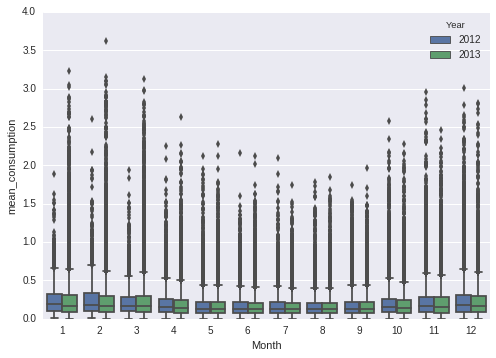

In [34]:
_ = sns.boxplot(x='Month',y='mean_consumption', hue = 'Year', data = ToU_hour)

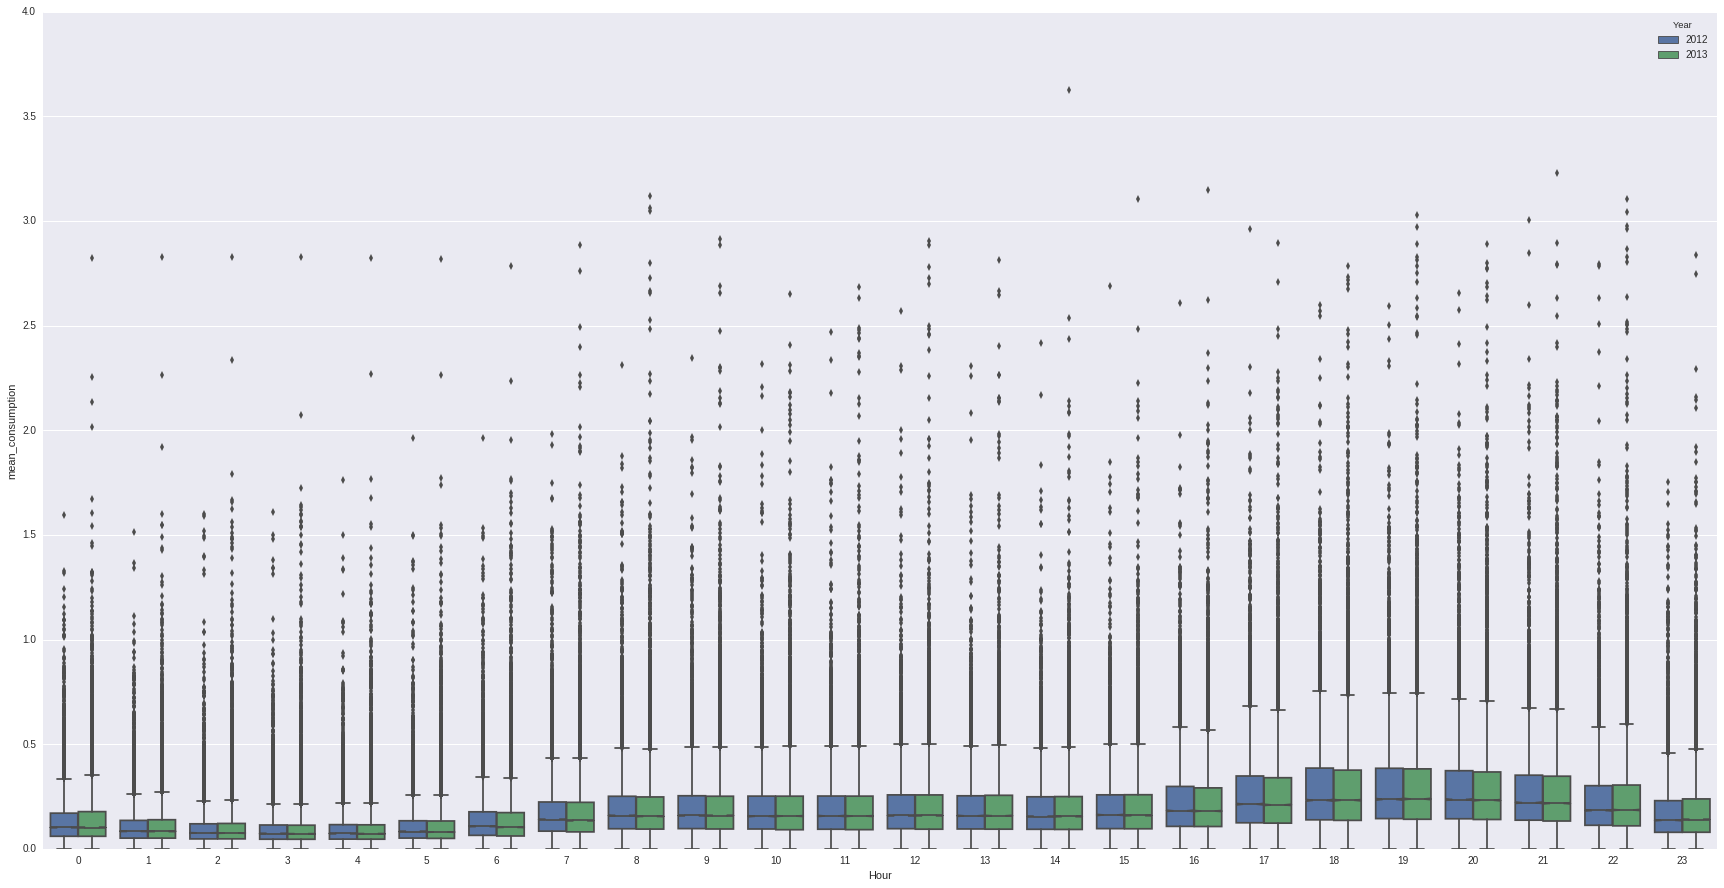

In [35]:
plt.figure(figsize=(30,15))
_ = sns.boxplot(x='Hour',y='mean_consumption', hue = 'Year', data = ToU_hour, notch = True)

These charts are not so informative after all.

Therefore, we need a metric to characterise customer behavioural changes. A reasonable and simple one is to calculate the difference between the mean price paid in 2013 and the hypothetical mean price that the same customer would have paid in 2012 in subjected to the same dToU tariff. This does not account for the weather component but does take into account all seasonal effects (month, weekday, hour...).

In [36]:
ToU_hour_mean_price = \
    pd.DataFrame(data= {'price_2013': ToU_hour_2013.groupby(['ID', 'ACORN','ACORN_grouped']).mean()['mean_price'],
                        'price_2012': ToU_hour_2012.groupby(['ID', 'ACORN','ACORN_grouped']).mean()['mean_price']})

In [37]:
ToU_hour_mean_price['reaction'] = ToU_hour_mean_price['price_2012'] - ToU_hour_mean_price['price_2013']

With this definition, a negative value of reaction indicates that a customer has paid less in 2013 than what he would have paid with the same tariff applied in 2012, suggesting this user reacted positively to the dToU tariff applied in 2013.

In [38]:
ToU_hour_mean_price = ToU_hour_mean_price.reset_index()

In [39]:
ToU_hour_mean_price.sample(5)

,ID,ACORN,ACORN_grouped,price_2012,price_2013,reaction
129,MAC000716,ACORN-E,Affluent,13.366687,13.193196,0.173490
534,MAC002668,ACORN-L,Adversity,13.530887,13.139428,0.391459
567,MAC002800,ACORN-E,Affluent,13.355852,13.379165,-0.023313
893,MAC004448,ACORN-D,Affluent,13.271065,13.131607,0.139458
961,MAC004770,ACORN-E,Affluent,13.046917,13.609119,-0.562203


In [40]:
ToU_hour_mean_price['reaction'].describe()

count    1112.000000
mean        0.094489
std         0.597633
min        -1.953651
25%        -0.219515
50%        -0.012828
75%         0.244330
max         5.471839
Name: reaction, dtype: float64

In [41]:
from scipy import stats
stats.percentileofscore(ToU_hour_mean_price['reaction'],0)

51.55832591273375

Only 51% of users have actually paid less for their kWh thanks to dToU compared to what they would have done keeping their consumption habits for the previous year. This figure is significantly lower than the 85% of users who actually saved money. This means, that many users did not really react to dToU but the structure of this tariff over the year actually made them pay less without a need to change the consumption patterns.

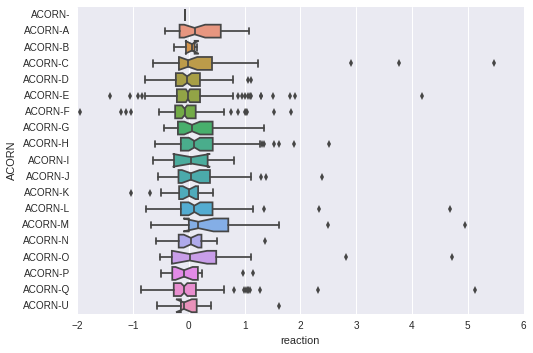

In [47]:
ACORN_levels = ToU_hour_mean_price['ACORN'].unique()
ACORN_levels.sort()
_ = sns.boxplot(x='reaction', y='ACORN', data=ToU_hour_mean_price
                , order = ACORN_levels, notch = True)

In [49]:
ToU_hour_mean_price.loc[(ToU_hour_mean_price['ACORN_grouped'] == 'ACORN-U') 
               | (ToU_hour_mean_price['ACORN_grouped'] == 'ACORN-'),'ACORN_grouped'] = 'Undefined'

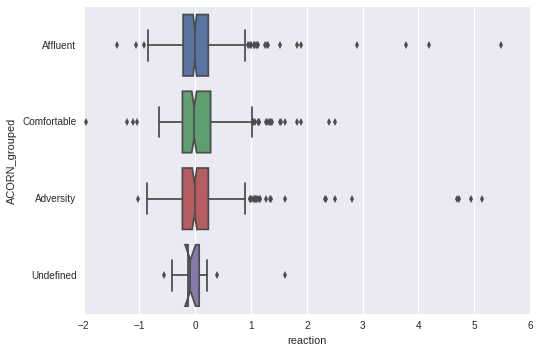

In [50]:
_ = sns.boxplot(x='reaction', y='ACORN_grouped', data=ToU_hour_mean_price,
                order = ['Affluent', 'Comfortable', 'Adversity', 'Undefined'], notch = True)

If we consider only the three top level ACORN groups (economic segmentation), medians are not significantly different as shown in the boxplot.

Instead of these three groups we will consider the six top level groups as descibed in the ACORN guide. These are more representative while keeping the number of groups low (with three, we consider multimillionaires and urban upper-middle class people in the same group, in the same way as students and recent graduates are merged with and unemployed or low-income families with no higher education).

-Affluent: A, B, C.

-Rising: D, E.

-Comfortable: F, G, H, I, J.

-Stretched: K, L, M, N.

-Adversity: O, P, Q.

-Not Private: R (is not present in the dataset).

In [86]:
ToU_hour_mean_price.loc[ToU_hour_mean_price['ACORN'].isin(['ACORN-A','ACORN-B','ACORN-C']), 'ACORN_grouped'] = 'Affluent'
ToU_hour_mean_price.loc[ToU_hour_mean_price['ACORN'].isin(['ACORN-D','ACORN-E']), 'ACORN_grouped'] = 'Rising'
ToU_hour_mean_price.loc[ToU_hour_mean_price['ACORN'].isin(['ACORN-F','ACORN-G','ACORN-H','ACORN-I','ACORN-J']),
                        'ACORN_grouped'] = 'Comfortable'
ToU_hour_mean_price.loc[ToU_hour_mean_price['ACORN'].isin(['ACORN-K','ACORN-L','ACORN-M','ACORN-N']),
                        'ACORN_grouped'] = 'Stretched'
ToU_hour_mean_price.loc[ToU_hour_mean_price['ACORN'].isin(['ACORN-O','ACORN-P','ACORN-Q']),
                        'ACORN_grouped'] = 'Adversity'

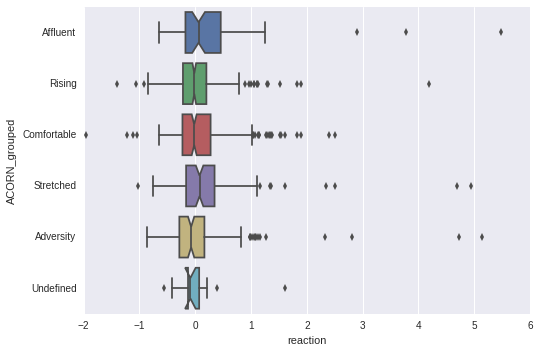

In [87]:
_ = sns.boxplot(x='reaction', y='ACORN_grouped', data=ToU_hour_mean_price,
        order = ['Affluent', 'Rising', 'Comfortable', 'Stretched', 'Adversity', 'Undefined'], notch = True)

It is clear that in all groups there are users who change their behaviour to profit from the lower prices offered by dToU in certain periods of time while others end up paying even more than they would have done with a flat rate tariff. The wealthiest group does worse, with a median reaction above 0. It is expected that this group of users does not have great motivation in saving money from their electricity bill. On the other hand, the lowest income group has a significantly lower median (and significantly below 0), although many users in this group are not reacting to dToU. In the Rising and - especially - Comfortable groups, there is a large spread, with outliers in both directions.

The top 10 performing users are:

In [63]:
ToU_hour_mean_price[['ID','ACORN','ACORN_grouped','reaction']].sort_values('reaction')[:10]

,ID,ACORN,ACORN_grouped,reaction
1010,MAC005069,ACORN-F,Comfortable,-1.953651
345,MAC001712,ACORN-E,Affluent,-1.403850
256,MAC001290,ACORN-F,Comfortable,-1.213249
254,MAC001281,ACORN-F,Comfortable,-1.119491
460,MAC002264,ACORN-E,Affluent,-1.062310
936,MAC004691,ACORN-F,Comfortable,-1.038443
91,MAC000537,ACORN-K,Adversity,-1.031201
917,MAC004610,ACORN-E,Affluent,-0.909298
633,MAC003102,ACORN-Q,Adversity,-0.855730
599,MAC002930,ACORN-E,Affluent,-0.842380


The top 5 performing groups on average are:

In [57]:
ToU_hour_mean_price.groupby(['ACORN','ACORN_grouped']).mean()['reaction'].sort_values()[:5]

ACORN    ACORN_grouped
ACORN-   Undefined       -0.071297
ACORN-K  Adversity       -0.064659
ACORN-F  Comfortable     -0.038997
ACORN-B  Affluent        -0.003137
ACORN-P  Adversity        0.013565
Name: reaction, dtype: float64

As there are outliers, the median could be more informative

In [61]:
ToU_hour_mean_price.groupby(['ACORN','ACORN_grouped']).median()['reaction'].sort_values()[:5]

ACORN    ACORN_grouped
ACORN-U  Undefined       -0.087557
ACORN-P  Adversity       -0.084321
ACORN-Q  Adversity       -0.083649
ACORN-F  Comfortable     -0.076481
ACORN-   Undefined       -0.071297
Name: reaction, dtype: float64

Of the top 10 performers, 4 are in group E and 4 in group F. F also has the second best mean and fourth best median. F are middle-class users who live in countryside communities while group is composed by young career-driven families, first buyers and people living in mixed metropolitan areas. They are educated young people rising in prosperity, with heavy internet use (including online shopping).

Both groups have a large variability, as we saw in the mean price data analysis. Some have a strong reaction to dToU while others do not seem to care much. 

P and Q users also have a positive reaction to tariff changes. ACORN-P is described as a mixture of poorer families with many children, low income terraced housing, multi-ethnic, purpose-built estates and low income families in social rented semis, while Q users are single parents and families in social rented flats, singles and young families and people living in deprived areas and high-rise flats.

For these groups, comparing user behaviour with flat rate and dynamic tariff did not change our conclusions. However, our calculation of user reaction to dToU has uncovered K users are also doing well. This group is made of students or recent graduates, people with a low income but higher education.

The bottom 10 performers are:

In [88]:
ToU_hour_mean_price[['ID','ACORN','ACORN_grouped','reaction']].sort_values('reaction',ascending=False)[:10]

,ID,ACORN,ACORN_grouped,reaction
688,MAC003387,ACORN-C,Affluent,5.471839
1120,MAC005557,ACORN-Q,Adversity,5.136090
691,MAC003399,ACORN-M,Stretched,4.943475
689,MAC003390,ACORN-O,Adversity,4.722190
690,MAC003396,ACORN-L,Stretched,4.688824
68,MAC000418,ACORN-E,Rising,4.188096
685,MAC003366,ACORN-C,Affluent,3.771055
684,MAC003365,ACORN-C,Affluent,2.901936
687,MAC003379,ACORN-O,Adversity,2.817309
686,MAC003372,ACORN-H,Comfortable,2.513035


The bottom 5 performing groups on average are:

In [58]:
ToU_hour_mean_price.groupby(['ACORN','ACORN_grouped']).mean()['reaction'].sort_values(ascending = False)[:5]

ACORN    ACORN_grouped
ACORN-M  Adversity        0.624542
ACORN-O  Adversity        0.513486
ACORN-C  Affluent         0.436462
ACORN-L  Adversity        0.239227
ACORN-H  Comfortable      0.217105
Name: reaction, dtype: float64

And the 5 groups with worse median:

In [62]:
ToU_hour_mean_price.groupby(['ACORN','ACORN_grouped']).median()['reaction'].sort_values(ascending = False)[:5]

ACORN    ACORN_grouped
ACORN-M  Adversity        0.172632
ACORN-A  Affluent         0.104124
ACORN-L  Adversity        0.101426
ACORN-H  Comfortable      0.100608
ACORN-G  Comfortable      0.058863
Name: reaction, dtype: float64

C group (with 24 members) has 3 users in the bottom 10 but is not in the worse 5 groups by median. This suggest there is a large spread with a few outliers in the no reaction side. This group is made up mostly of wealthy villagers, settled older people living in suburban areas and retired and single well-off people, so it is quite heterogeneous.

ACORN-M is the group with the worst reaction, as was also suggested by looking at the mean price values. Our reaction metric shows their behaviour is significantly worse than that of most other groups, with no outliers and only 25% of users reacting to dToU (as opposed to 51% overall). These are a mixture of struggling young families in post-war terraces, people with limited means in post-war estates, semi-rural estates and families in right-to-buy estates. There is a large amount of lone parents, people enjoying benefits and lower than average internet, smartphone and tablet use.

Finally, this analysis has also uncovered ACORN-L as a group reacting very mildly to the dynamic tariff. When analysing the mean price in 2013 this group did not brought our attention as it is actually lower than that of other groups. However, as shown by our reaction metric, this seems to be a matter of luck, as most users did not really change their consumptuion patterns, but this happened to benefit from the tariff. Nonetheless, one could also argue that as their usual behaviour was already well adapted to the profile of the dynamic tariff they did not have so much room for further adaption. This group is made of people living in low cost flats in suburban areas, semi-skilled workers, owners of cheaper terraces and high occupancy terraces (with many Asian families).

Finally, let us compare the fraction of users who reacted to the dynamic tariff (reaction < 0) to complete our analysis. Now we will not look at the values but just at how many users have reacted to the tariff.

In [96]:
ToU_group_reaction = \
    ToU_hour_mean_price[ToU_hour_mean_price['reaction']<0].groupby(['ACORN', 'ACORN_grouped']).count()['ID']\
    /ToU_hour_mean_price.groupby(['ACORN', 'ACORN_grouped']).count()['ID']

In [104]:
ToU_group_reaction = ToU_group_reaction.reset_index()

In [110]:
ToU_group_reaction = ToU_group_reaction.rename(columns={'ID':'fraction'})

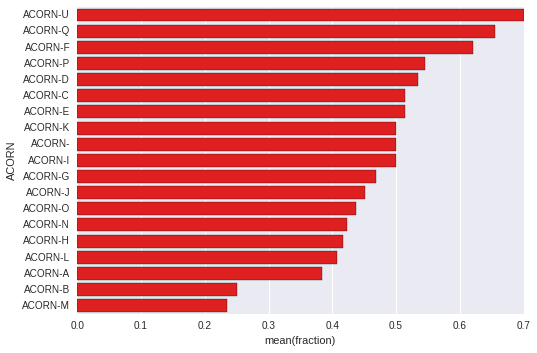

In [133]:
acorn_sorted = ToU_group_reaction.sort_values('fraction', ascending = False)['ACORN']
_ = sns.barplot(y = 'ACORN', x = 'fraction', data = ToU_group_reaction, order = acorn_sorted, color = 'red', orient = 'h')

Group M is again clearly the worse performer but this binary metric has also uncovered the B group as one in which many users do not react to the tariff. Actually, of the highest-income groups C is clearly the best with slightly over 50% of users reacting. Group A is that of the richest families, living in luxury houses. Group B, in which just around 25% of users react contains asset rich families but also affluent professionals and families. Groups Q, F and P are again top 3 performers.

#### Conclusion

Dynamic Time of Use tariff can be effective to influence the electricity consumption patterns of customers, decreasing consumption when prices are high and increasing them when they are low. Utilities can use them to improve consumption prediction, flatten the aggregate demand curve or defer consumption to periods when power generation is abundant (for example, when wind and other renewables kick in). Nevertheless, the degree to which different users react to tariff changes has a very large variation, with around 50% of our sample not being to react at all. 

In this case, the dToU tariff helped 85% of customers save many, but some of them did not even have to change their behaviour. This is not the best case for a utility, as it reduces its income while not obtaining much benefit in terms of demand predictability.

In any case it seems the ACORN segmentation is not so effective to predict a user's behaviour, with all groups containing households that react and others than do not to the dToU tariff. It is true, however, that the less affluent groups do not have any of the top spenders among their ranks. These are presumably more compelled to save money from the meager incomes and take more care about profiting from a variable tariff.

First, most ACORN "letter" groups are quite heterogeneous and mostly, but not only, based on income. This segmentation actually contains smaller groups (labelled with numbers) that narrow down socioeconomic characteristics (age, education, neighbourhood and housing type). In any case, it is very likely that other factors that cannot be known or even hinted at with the full ACORN grouping influence consumer behaviour: a user's attitude towards the environment, hobbies (for example, a football fan will not defer his TV consumption when watching a game even if the tariff is high) and working hours (dToU tariff was higher on average in the evening hours).

Finally, we should also bear in mind that this kind of schemes require customer "learning" or adaption. A user must change his consumption behaviour, which has been learnt for years, taking new variables into account, so the success of a dynamic tariff is expected to increase over time in the first few years. Surely, it is very unlikely that all users react to a variable tariff and this shall not be the aim. In our dataset roughly half of the users reacted to some degree by deferring their consumption to periods of lower prices, so a utility could benefit from this effect, as it has been discussed. In the next section we will see if this enhances aggregate electricity demand prediction, which is another of the main aims of dynamic tariffs.